## Example 9.1: State Aggregation on the 1000-State Random Walk

Consider a 1000-state version of the random walk task (Examples 6.2 and 7.1 on pages 125 and 144). The states are numbered from 1 to 1000, left to right, and all episodes begin near the center, in state **500**.

State transitions are from the current state to one of the **100 neighboring states to its left** or to one of the **100 neighboring states to its right**, all with equal probability.

If the current state is near an edge, then there may be fewer than 100 neighbors on that side. In this case, all the probability that would have gone into those missing neighbors goes into the probability of terminating on that side.

For example:

* State **1** has a 0.5 chance of terminating on the left.
* State **950** has a 0.25 chance of terminating on the right.

**Rewards**:

* Termination on the left produces a reward of **–1**.
* Termination on the right produces a reward of **+1**.
* All other transitions have a reward of **0**.

We use this task as a running example throughout this section.


In [8]:
import numpy as np
import matplotlib.pyplot as plt

num_states = 1000
max_step = 100
p_each = 1.0 / (2 * max_step)

A = np.zeros((num_states, num_states), dtype=np.float64)
b = np.zeros(num_states, dtype=np.float64)

for s in range(1, num_states + 1):
    row = s - 1
    for k in range(1, max_step + 1):
        left = s - k
        if left >= 1:
            A[row, left - 1] += p_each
        else:
            b[row] += -1.0 * p_each
        right = s + k
        if right <= num_states:
            A[row, right - 1] += p_each
        else:
            b[row] += +1.0 * p_each

TRUE_VALUES = np.linalg.solve(np.eye(num_states, dtype=np.float64) - A, b)


def get_next_state_and_reward(state, action):
    proposed_next_state = state + action
    if proposed_next_state < 1:
        return 'terminal', -1
    elif proposed_next_state > num_states:
        return 'terminal', 1
    else:
        return proposed_next_state, 0

def get_next_action():
    action = np.random.randint(-100, 101)
    if action == 0:
        action = np.random.choice([-1, 1])
    return action

def generate_episode():
    state = 500
    episode = []
    while state != 'terminal':
        action = get_next_action()
        next_state, reward = get_next_state_and_reward(state, action)
        episode.append((state, action, reward))
        state = next_state
    return episode

def get_vector_from_state(state):
    # one hot encoding
    vector = np.zeros(10)
    position = (state - 1) // 100
    vector[position] = 1
    return vector

def value_function(W, state):
    return np.dot(W, get_vector_from_state(state))

def gradient_monte_carlo(W, state):
    return get_vector_from_state(state)

def train_gradient_monte_carlo(num_episodes, alpha):
    W = np.zeros(10)
    for _ in range(num_episodes):
        episode = generate_episode()
        episode_return = episode[-1][2]
        for state, _, _ in episode:
            W += alpha * (episode_return - value_function(W, state)) * gradient_monte_carlo(W, state)
    return W

W = train_gradient_monte_carlo(100000, 2e-5)

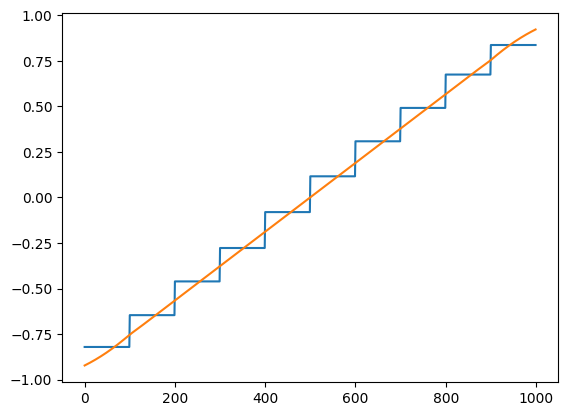

In [9]:
# generate values for the 1000 states
values = np.zeros(num_states)
for state in range(1, num_states + 1):
    values[state - 1] = value_function(W, state)

plt.plot(values)
plt.plot(TRUE_VALUES)
plt.show()